In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_1samp

import warnings
warnings.filterwarnings('ignore')

# import preprocessing

In [59]:
quant = ['peg', 'ncav', 'low']
# fname = '../datasets/rtns_' + quant[0] + '.csv' # peg --> 유의하지 않음 t;jaelwfkmdszcvx;oilkm,
fname = '../datasets/rtns_' + quant[1] + '.csv' # ncav --> 산타랠리 유의함

df_rtns = pd.read_csv(fname, index_col=0)
df_rtns.index = pd.to_datetime(df_rtns.index)

df_rtns['rtn_portfolio'] *= 100
df_rtns.columns = ['rtn_portfolio', '귀속년도', 'event', 'rtn_market']
df_rtns

,rtn_portfolio,귀속년도,event,rtn_market
2008-12-12,-1.030230,2008,before,-4.383991
2008-12-15,4.247748,2008,before,4.925622
2008-12-16,0.929976,2008,before,0.290981
2008-12-17,-0.699803,2008,before,0.705081
2008-12-18,0.707293,2008,before,0.526611
...,...,...,...,...
2023-12-26,-0.051410,2023,santa,0.118487
2023-12-27,-1.330641,2023,santa,0.419194
2023-12-28,0.698222,2023,santa,1.598624
2024-01-02,-0.378831,2023,santa,0.547213


In [60]:
def ols(y, x):
    # ols regression
    # y = a + bx + e
    ## y : portfolio 수익률
    ## x : market 수익률
    ## e : 오차항(=0)

    x = sm.add_constant(x) # 상수항(a) 추가

    model = sm.OLS(y, x) # ols 모델 생성
    results = model.fit() # ols 모델 적합(a, b 추정)

    # results.params.values : (추정a, 추정b)
    hat_a, hat_b = results.params.values
    return (hat_a, hat_b), results

In [61]:
import scipy.stats as stats
from scipy.stats import wilcoxon

def test_aers(aers, alpha=0.05):
    # 표본의 크기 > 30
    print(f'검정 표본 크기 : {len(aers)}')
    
    # 정규성 검정 (Shapiro-Wilk test)
    stat, p_value = stats.shapiro(aers)

    print(f"정규성 검정: Statistic = {stat}, p-value = {np.round(p_value, 4)}")
    print(f'-> 정규성 만족 여부 : {p_value > 0.05}')

    # Wilcoxon Signed Rank Test 수행
    statistic, p_value = wilcoxon(aers - 0, alternative='greater')
    print(f"Wilcoxon Signed Rank 검정: Statistic = {statistic}, p-value = {np.round(p_value, 4)}")
    res_wilcoxon = p_value < 0.05
    print(f"-> 검정 결과 {'H0 기각, H1 채택(평균AER > 0)' if res_wilcoxon else 'H0 기각 불가'}")

    # 일표본 t-검정(단측검정)
    # H1 : mean(초과수익률) > 0 (pvalue < 0.05)
    result_ttest = ttest_1samp(aers, 0, alternative='greater')
    return result_ttest

In [62]:
def model_market(
        data,
        year_start = 2000,
        year_end = 2021,
        col_year = '귀속년도',
        col_rtn = 'rtn',
        col_event = 'event',
        val_event = 'santa',
        _print=True
    ):
    col_portfolio = col_rtn + '_portfolio'
    col_market = col_rtn + '_market'

    """ (1) 추정기간의 자료를 바탕으로 정상적인 기대수익률 모형 추정 """
    
    # 추정 기간의 자료
    data_before = data[data[col_event] != val_event]

    # 실제 수익률
    y = data_before[col_portfolio] # 포트폴리오 일 수익률
    x = data_before[col_market] # 시장 일 수익률

    # 알파, 베타 추정
    (hat_alpha, hat_beta), result_ols = ols(y, x)

    # 
    if _print:
        print("시장모형 추정 결과")
        print(result_ols.summary())
        print()


    """ (2) Event 기간의 자료를 바탕으로 정상적인 기대수익률 모형 값을 연결하여 초과수익률 계산 """
    
    # Event 기간의 자료
    data_event = data[data[col_event] == val_event]

    # 실제 수익률
    rtns_portfolio = data_event[col_portfolio] # 포트폴리오 일 수익률
    rtns_market = data_event[col_market] # 시장 일 수익률

    # 정상적 기대수익률 추정
    hat_portfolio = hat_alpha + hat_beta * rtns_market
    # hat_portfolio = result_ols.predict(rtns_market)

    data_event['hat_portfolio'] = hat_portfolio

    # 초과수익률(=비정상수익률) 계산 : 실제수익률 - 추정된 정상적 기대수익률
    aers = rtns_portfolio - hat_portfolio
    data_event['aers'] = aers

    # 
    if _print:
        print("연도별 초과수익률 평균")
        print(data_event[[col_year, 'aers']].groupby(col_year).mean())
        print()


    """ (3) 초과수익률의 유의성 검정 """
    result_test = test_aers(data_event['aers'])
    
    if _print:
        print("초과수익률 유의성 검정 (T-Test) 결과")
        print(result_test)
    if result_test.pvalue < 0.05:
        print(f"유의수준 0.05하에서 T-Test 검정 결과, pvalue={np.round(result_test.pvalue,4)}로 초과수익률이 유의함(초과수익률>0)")
    else:
        print("Event Study 결과, 초과수익률이 유의하지 않음")

    return data_event, (result_ols.summary(), result_test)

In [63]:
def study(
    data = None, 
    col_rtn = 'rtn',
    col_event = 'event', 
    _print=False
):
    # Event기간(data[col_event]=='santa')과 
    # 추정기간(data[col_event]=='before')의
    # 데이터만 남기기
    data = data[
        (data[col_event]=='santa') | (data[col_event] == 'before')
    ]
    data_event, results = model_market(data, _print=_print)

    return data, data_event, results

In [64]:
data, data_event, results = study(df_rtns)

검정 표본 크기 : 112
정규성 검정: Statistic = 0.9408648610115051, p-value = 0.0001
-> 정규성 만족 여부 : False
Wilcoxon Signed Rank 검정: Statistic = 4258.0, p-value = 0.0007
-> 검정 결과 H0 기각, H1 채택(평균AER > 0)
유의수준 0.05하에서 T-Test 검정 결과, pvalue=0.0036로 초과수익률이 유의함(초과수익률>0)


In [65]:
data_event

,rtn_portfolio,귀속년도,event,rtn_market,hat_portfolio,aers
2008-12-23,-1.373688,2008,santa,-2.992508,-1.510832,0.137143
2008-12-24,-1.002787,2008,santa,-1.380749,-0.706550,-0.296237
2008-12-26,-0.020691,2008,santa,-0.943724,-0.488471,0.467780
2008-12-29,-0.153093,2008,santa,-0.024155,-0.029598,-0.123495
2008-12-30,2.703559,2008,santa,0.615611,0.289651,2.413909
...,...,...,...,...,...,...
2023-12-26,-0.051410,2023,santa,0.118487,0.041582,-0.092991
2023-12-27,-1.330641,2023,santa,0.419194,0.191637,-1.522279
2023-12-28,0.698222,2023,santa,1.598624,0.780183,-0.081960
2024-01-02,-0.378831,2023,santa,0.547213,0.255519,-0.634350


<AxesSubplot:>

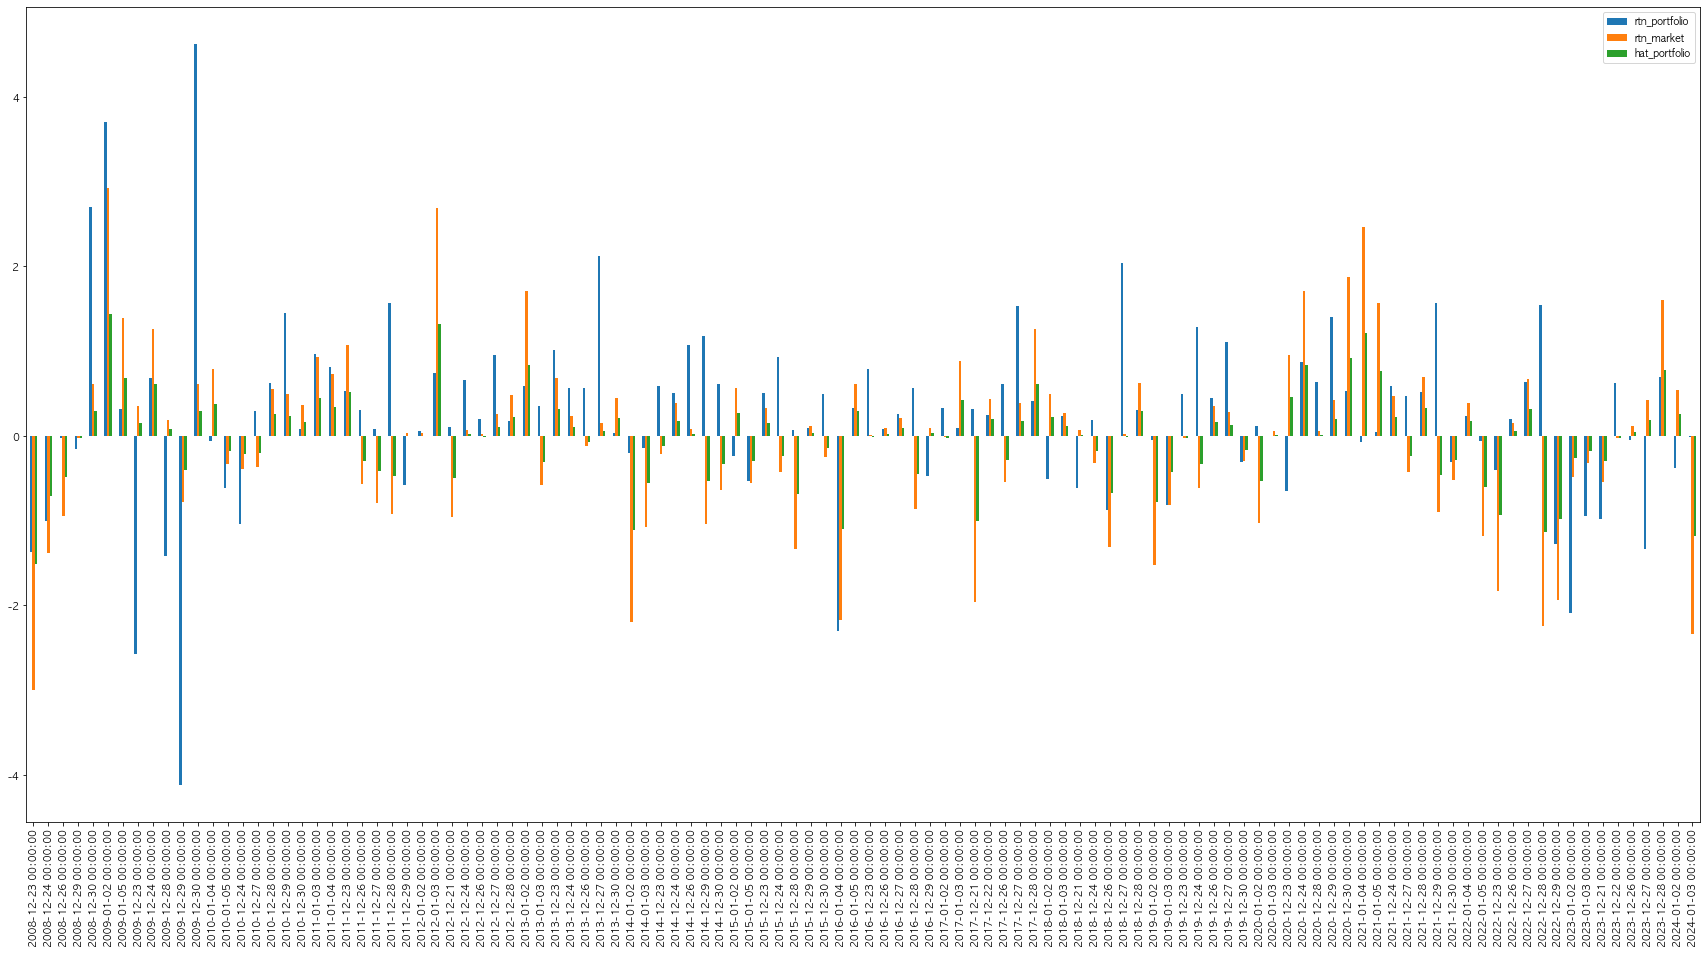

In [66]:
data_event[['rtn_portfolio', 'rtn_market', 'hat_portfolio']].plot(figsize=(30, 15), kind='bar')

In [67]:
data_event['event'].value_counts()

santa    112
Name: event, dtype: int64

In [68]:
# data.groupby(['event', '귀속년도']).mean()

data.pivot_table(
    index='귀속년도',
    columns='event',
    aggfunc='mean'
)

rtn_market           rtn_portfolio          
event     before     santa        before     santa
귀속년도                                              
2008    0.339921 -0.057134      0.646837  0.595684
2009   -0.010503  0.302017      0.403249 -0.494687
2010    0.202404  0.331651      0.145874  0.457209
2011   -0.107575  0.221428     -0.014229  0.387277
2012    0.306142  0.144713      0.034222  0.435264
2013    0.039336 -0.265704     -0.080124  0.565976
2014    0.199403 -0.200987     -0.421522  0.455590
2015    0.322376 -0.446564      0.488076  0.018504
2016   -0.001616  0.058841      0.137476  0.233537
2017    0.084978  0.049608     -0.405315  0.407852
2018    0.053729 -0.464439      0.200161  0.027268
2019    0.658029 -0.179554      0.045721  0.445523
2020   -0.186633  1.294418     -0.078853  0.393870
2021    0.051830 -0.209664     -0.062887  0.431012
2022   -0.090349 -0.852986      0.011291 -0.333169
2023    0.499183 -0.031902     -0.152703 -0.204953

In [69]:
data_event

,rtn_portfolio,귀속년도,event,rtn_market,hat_portfolio,aers
2008-12-23,-1.373688,2008,santa,-2.992508,-1.510832,0.137143
2008-12-24,-1.002787,2008,santa,-1.380749,-0.706550,-0.296237
2008-12-26,-0.020691,2008,santa,-0.943724,-0.488471,0.467780
2008-12-29,-0.153093,2008,santa,-0.024155,-0.029598,-0.123495
2008-12-30,2.703559,2008,santa,0.615611,0.289651,2.413909
...,...,...,...,...,...,...
2023-12-26,-0.051410,2023,santa,0.118487,0.041582,-0.092991
2023-12-27,-1.330641,2023,santa,0.419194,0.191637,-1.522279
2023-12-28,0.698222,2023,santa,1.598624,0.780183,-0.081960
2024-01-02,-0.378831,2023,santa,0.547213,0.255519,-0.634350


In [70]:
data[data['event']=='santa']

,rtn_portfolio,귀속년도,event,rtn_market
2008-12-23,-1.373688,2008,santa,-2.992508
2008-12-24,-1.002787,2008,santa,-1.380749
2008-12-26,-0.020691,2008,santa,-0.943724
2008-12-29,-0.153093,2008,santa,-0.024155
2008-12-30,2.703559,2008,santa,0.615611
...,...,...,...,...
2023-12-26,-0.051410,2023,santa,0.118487
2023-12-27,-1.330641,2023,santa,0.419194
2023-12-28,0.698222,2023,santa,1.598624
2024-01-02,-0.378831,2023,santa,0.547213


In [71]:
data_event.pivot_table(
    index='귀속년도',
    columns='event',
    aggfunc='mean'
)

,aers,hat_portfolio,rtn_market,rtn_portfolio
event,santa,santa,santa,santa
귀속년도,,,,
2008,0.641739,-0.046055,-0.057134,0.595684
2009,-0.627852,0.133164,0.302017,-0.494687
2010,0.309257,0.147952,0.331651,0.457209
2011,0.294327,0.092950,0.221428,0.387277
2012,0.380596,0.054668,0.144713,0.435264
2013,0.716109,-0.150133,-0.265704,0.565976
2014,0.573429,-0.117839,-0.200987,0.455590
2015,0.258888,-0.240384,-0.446564,0.018504


In [72]:
# ols 회귀적합결과
# const -> alpha, rtn_market -> beta
results[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rtn_portfolio   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     49.81
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           1.60e-10
Time:                        01:13:43   Log-Likelihood:                -129.66
No. Observations:                 112   AIC:                             263.3
Df Residuals:                     110   BIC:                             268.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0175      0.074     -0.237      0.813      -0.165       0.129
rtn_market     0.4990      0.071      7.058      0.000       0.359       0.639
==============================================================================
Omnibus:                        3.080   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.495
Skew:                           0.279   Prob(JB):                        0.287
Kurtosis:                       3.473   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# 초과수익률 유의성 검정 T-Test
results[1]

Ttest_1sampResult(statistic=2.740770637667299, pvalue=0.0035726556128078788)

#### car 검정

In [74]:
# car : 이벤트 구간별 aer 누적합

cars = data_event.groupby('귀속년도')['aers'].sum()
cars

귀속년도
2008    4.492172
2009   -4.394963
2010    2.164801
2011    2.060287
2012    2.664170
2013    5.012766
2014    4.014001
2015    1.812216
2016    1.552038
2017    2.804495
2018    1.936000
2019    3.868667
2020   -1.641578
2021    3.872266
2022    0.770160
2023   -1.200423
Name: aers, dtype: float64

In [75]:
len(cars) # < 30 이라 t검정 신뢰도 떨어짐

16

<AxesSubplot:xlabel='귀속년도'>

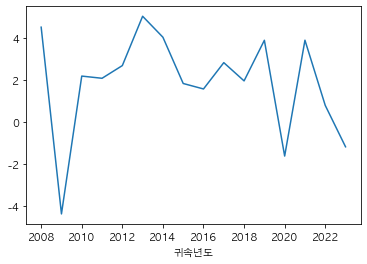

In [76]:
cars.plot()

In [77]:
import matplotlib.pyplot as plt
import platform
if platform.system() == 'Darwin': # MAC
    plt.rc('font', family='AppleGothic')
else: # Windows
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb2491eb490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb2491eba30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb2491eb1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb2491ebfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb2491f32e0>],
 'means': []}

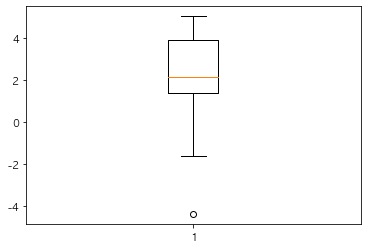

In [78]:
plt.boxplot(cars)

In [79]:
# mean(cars) != 0
# ttest_1samp(cars, 0).pvalue < 0.05

# mean(cars) > 0
ttest_1samp(cars, 0, alternative='greater').pvalue < 0.05

True

In [80]:
ttest_res = test_aers(cars)
ttest_res.pvalue < 0.05 # t테스트 결과

검정 표본 크기 : 16
정규성 검정: Statistic = 0.901317298412323, p-value = 0.0844
-> 정규성 만족 여부 : True
Wilcoxon Signed Rank 검정: Statistic = 116.0, p-value = 0.0055
-> 검정 결과 H0 기각, H1 채택(평균AER > 0)


True